In [2]:
%matplotlib inline

from zipline import run_algorithm
from zipline.api import order_target_percent, record, symbol, schedule_function, date_rules, time_rules

from datetime import datetime
import pytz

import matplotlib.pyplot as plt
import pandas as pd

import pyfolio as pf

In [3]:
def initialize(context):
    # Which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # Make symbol list from tickers
    context.universe = [symbol(s) for s in dji]
    
    # History window
    context.history_window = 20
    
    # Size of our portfolio
    context.stocks_to_hold = 10
    
    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())    
    
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
    
def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")
    
    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held.
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.items():
        stock_weight = 1 / context.stocks_to_hold

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.items():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)     
            
def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,4.336%
Cumulative returns,88.882%
Annual volatility,17.956%
Sharpe ratio,0.33
Calmar ratio,0.07
Stability,0.05
Max drawdown,-64.551%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,64.55,2007-10-31,2009-03-09,2017-11-30,2632
1,15.40,2003-01-06,2003-03-11,2003-05-12,91
2,10.43,2007-07-19,2007-08-28,2007-10-31,75
3,8.54,2007-01-16,2007-03-05,2007-04-25,72
4,8.20,2005-03-07,2005-04-28,2005-08-03,108


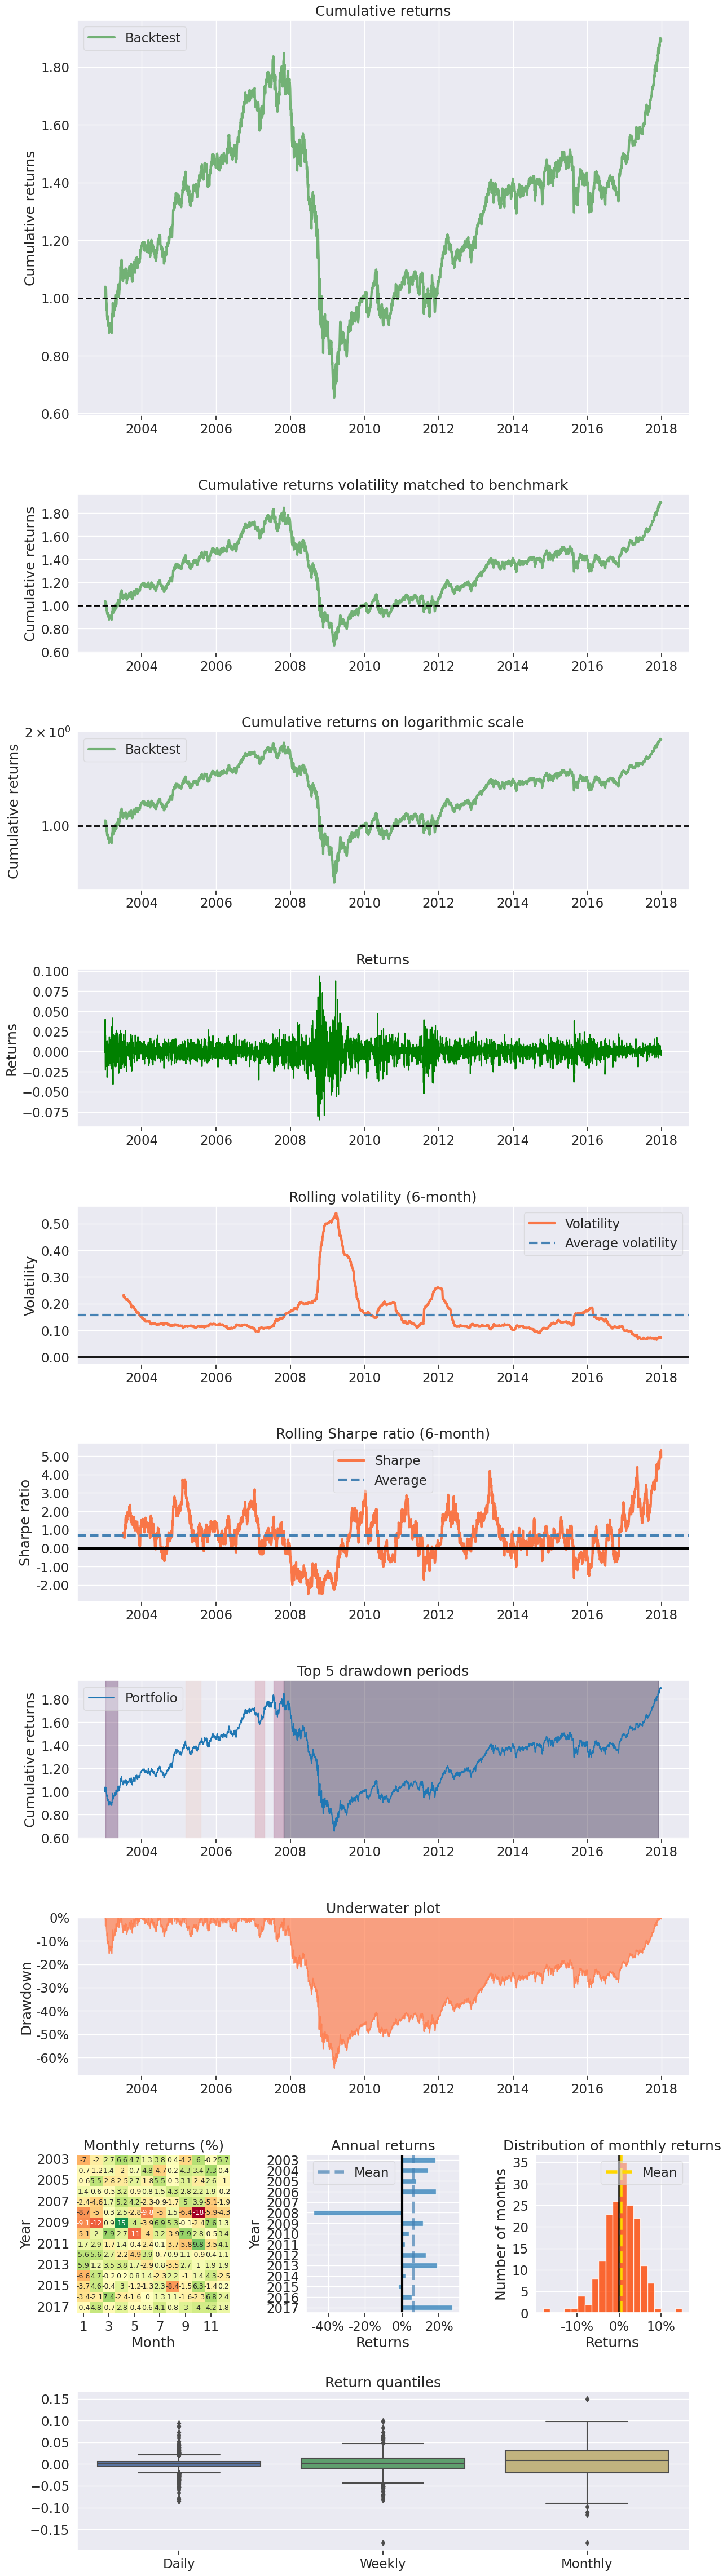

In [4]:
start_date = pd.Timestamp('2003-01-01').tz_localize(None)
end_date = pd.Timestamp('2017-12-31').tz_localize(None)

# Fire off the backtest
results = run_algorithm(
    start=start_date, 
    end=end_date, 
    initialize=initialize, 
    analyze=analyze, 
    handle_data=handle_data, 
    capital_base=10000, 
    data_frequency = 'daily',
    bundle='quandl' 
)

In [5]:
results

,period_open,period_close,gross_leverage,ending_cash,starting_value,ending_exposure,positions,starting_exposure,transactions,pnl,...,benchmark_volatility,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return
2003-01-02 00:00:00+00:00,2003-01-02 14:31:00+00:00,2003-01-02 21:00:00+00:00,0.000000,10000.00000,0.00,0.00,[],0.00,[],0.00000,...,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,1,2003-01,0.000000
2003-01-03 00:00:00+00:00,2003-01-03 14:31:00+00:00,2003-01-03 21:00:00+00:00,1.960722,-9597.35955,0.00,19587.10,"[{'sid': Equity(1576 [JPM]), 'amount': 78, 'co...",0.00,"[{'amount': 39, 'dt': 2003-01-03 21:00:00+00:0...",-10.25955,...,0.0,-11.224972,-11.224972,-0.001026,1.960722,0.0,0.0,2,2003-01,-0.001026
2003-01-06 00:00:00+00:00,2003-01-06 14:31:00+00:00,2003-01-06 21:00:00+00:00,1.004853,-50.42181,19587.10,10439.84,"[{'sid': Equity(1576 [JPM]), 'amount': 39, 'co...",19587.10,"[{'amount': -34, 'dt': 2003-01-06 21:00:00+00:...",399.67774,...,0.0,8.814960,348.245167,-0.001026,1.960722,0.0,0.0,3,2003-01,0.038942
2003-01-07 00:00:00+00:00,2003-01-07 14:31:00+00:00,2003-01-07 21:00:00+00:00,1.003224,-33.06992,10439.84,10288.99,"[{'sid': Equity(1576 [JPM]), 'amount': 38, 'co...",10439.84,"[{'amount': -1, 'dt': 2003-01-07 21:00:00+00:0...",-133.49811,...,0.0,4.496387,16.091738,-0.012849,1.960722,0.0,0.0,4,2003-01,0.025592
2003-01-08 00:00:00+00:00,2003-01-08 14:31:00+00:00,2003-01-08 21:00:00+00:00,0.995196,48.13556,10288.99,9971.14,"[{'sid': Equity(1576 [JPM]), 'amount': 37, 'co...",10288.99,"[{'amount': -1, 'dt': 2003-01-08 21:00:00+00:0...",-236.64452,...,0.0,0.405314,0.821789,-0.035627,1.960722,0.0,0.0,5,2003-01,0.001928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 00:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,0.982745,326.64735,18614.28,18604.42,"[{'sid': Equity(1321 [HD]), 'amount': 10, 'cos...",18614.28,"[{'amount': 15, 'dt': 2017-12-22 21:00:00+00:0...",-65.16200,...,0.0,0.327287,0.458925,-0.645508,1.960722,0.0,0.0,3772,2017-12,0.893107
2017-12-26 00:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,0.982775,326.64735,18604.42,18636.68,"[{'sid': Equity(1321 [HD]), 'amount': 10, 'cos...",18604.42,[],32.26000,...,0.0,0.327877,0.459752,-0.645508,1.960722,0.0,0.0,3773,2017-12,0.896333
2017-12-27 00:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,0.982754,326.64735,18636.68,18613.66,"[{'sid': Equity(1321 [HD]), 'amount': 10, 'cos...",18636.68,[],-23.02000,...,0.0,0.327381,0.459057,-0.645508,1.960722,0.0,0.0,3774,2017-12,0.894031
2017-12-28 00:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,0.986154,262.76178,18613.66,18714.54,"[{'sid': Equity(1321 [HD]), 'amount': 10, 'cos...",18613.66,"[{'amount': 41, 'dt': 2017-12-28 21:00:00+00:0...",36.99443,...,0.0,0.328063,0.460014,-0.645508,1.960722,0.0,0.0,3775,2017-12,0.897730


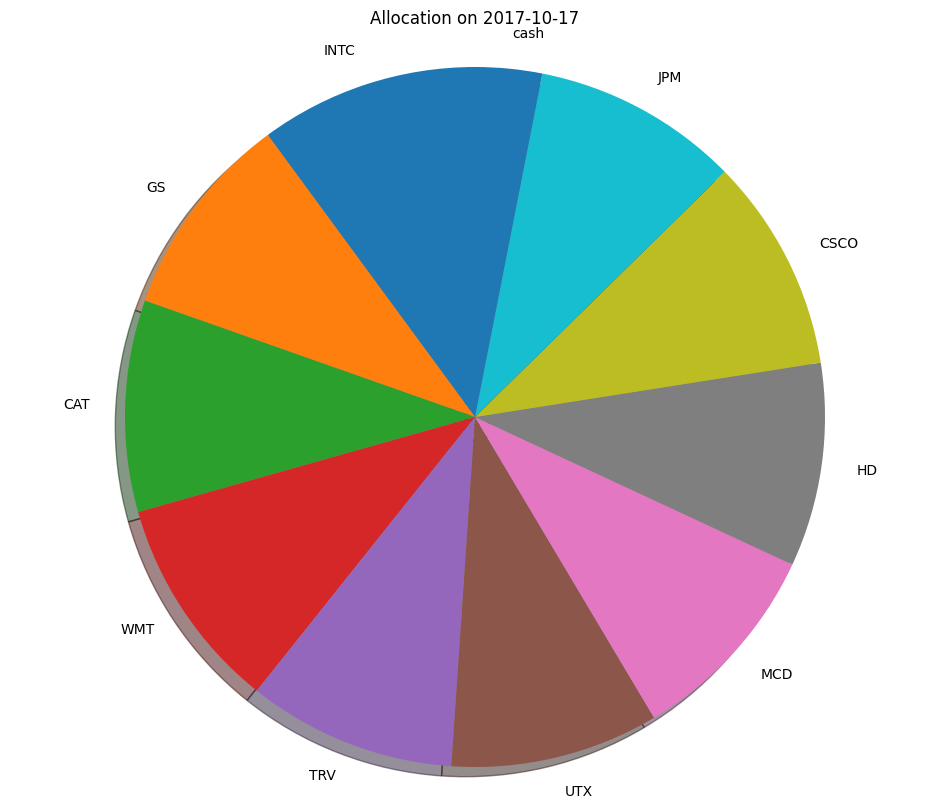

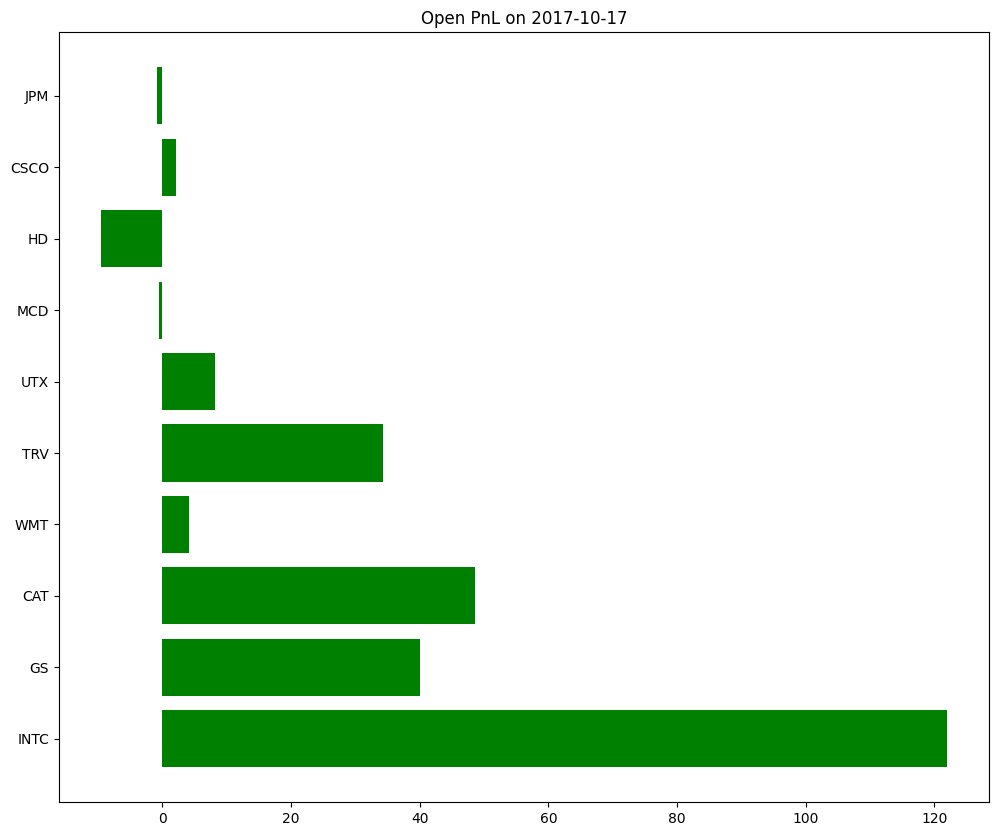

In [6]:
# Select day to view
day = '2017-10-17'

# Get portfolio value and positions for this day
port_value = results.loc[day,'portfolio_value']
day_positions = results.loc[day,'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# Add cash position
df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]    

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

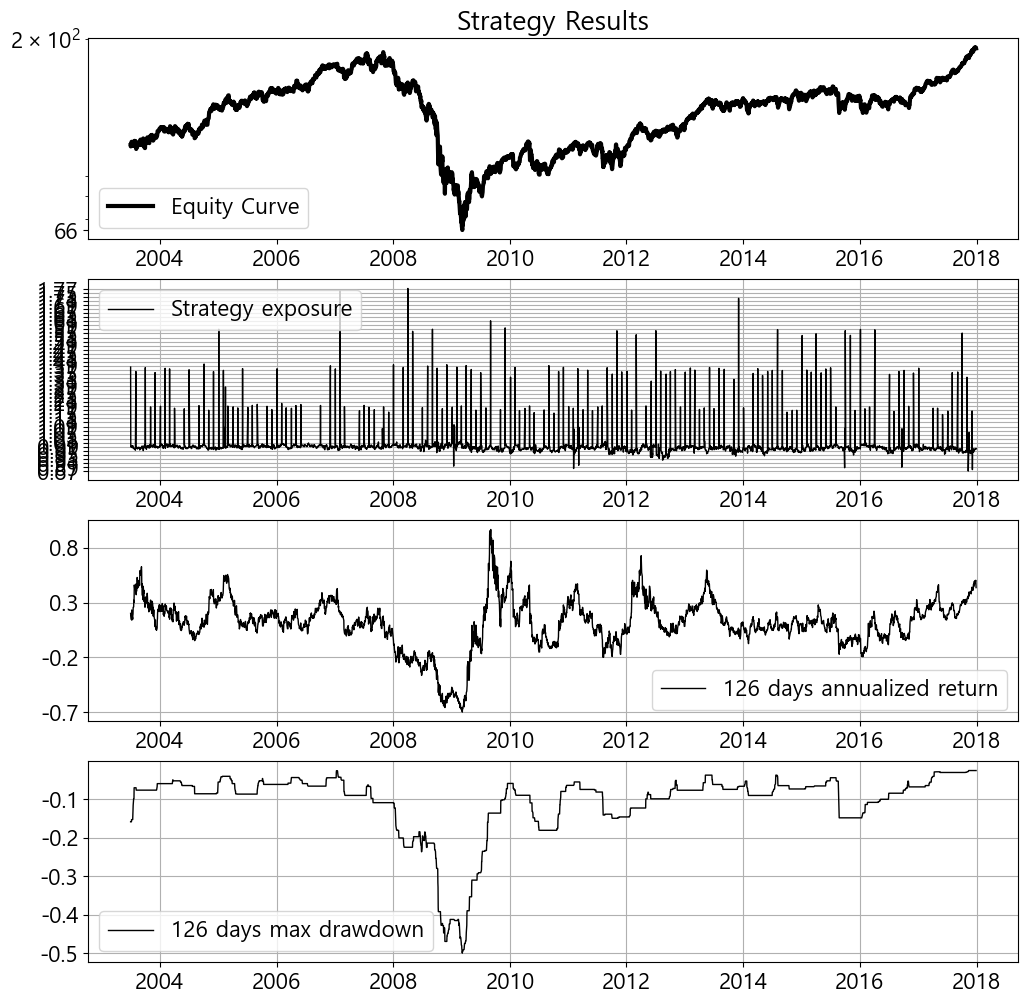

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as ticker

font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams['font.family'] = 'Malgun Gothic'

calc_window = 126
year_length = 252

df = results.copy().filter(items=['portfolio_value', 'gross_leverage'])

# 연율화 수익률
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# 낙폭
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

rolling_window = results.portfolio_value.rolling(calc_window)

df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)
df.dropna(inplace=True)

# 시각화
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# 첫번째 차트
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

ax.set_yscale('log') 
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax.legend()
ax.grid(False)

# 두번째 차트
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.legend()
ax.grid(True)

# 세번째 차트
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.legend()
ax.grid(True)

# 네번째 차트
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.legend()
ax.grid(True)